# Seq-2-Seq Based Time Series Forecasting Using Deep Stacked Unidirectional and Bidirectional LSTMs in Keras

This project is highly inspired from this post "https://weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/" by Weimin Wang. 

This notebook aims to implement s2q2seq encoder-decoder based architectures using LSTM networks. Single/multi layered Uni-directional and bi-directional LSTMs have been tried and implemented on the standard "daily minimum temperatures in melbourne" univariate timeseries dataset.

The main aim is to highlight the effectiveness of bi-directional LSTMs in learning complex patterns in the data.

In [1]:
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

C:\Users\MA20018398\AppData\Local\conda\conda\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Read data 
The original dataset requires a very little cleaning which I have done manually, so you can find the cleaned dataset in my GitHub repository.

In [2]:
data = pd.read_csv("daily-minimum-temperatures-in-me.csv")

In [523]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date        3650 non-null object
Min_temp    3650 non-null float64
dtypes: float64(1), object(1)
memory usage: 57.1+ KB


In [524]:
data.head()

,Date,Min_temp
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [3]:
data['Min_temp'] = data['Min_temp'].apply(lambda x: float(x))

In [4]:
series = data['Min_temp']

In [5]:
seq = series.copy()

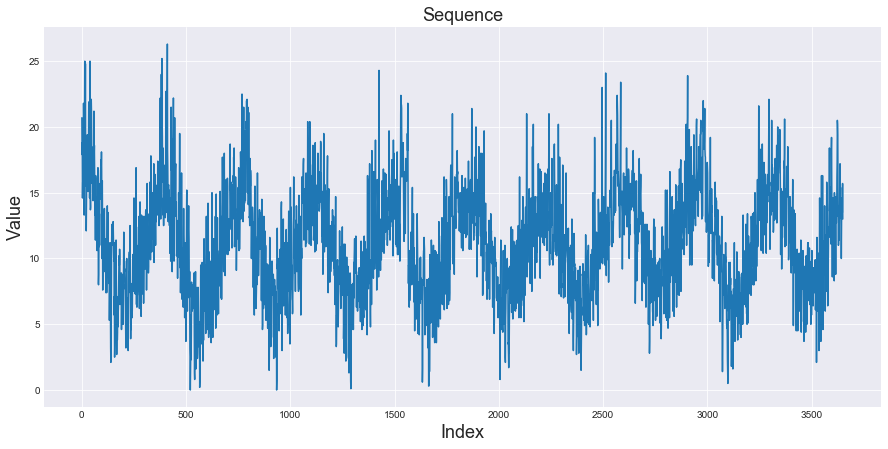

In [528]:
plt.figure(figsize=(15,7))
plt.title("Sequence", fontsize = 18)
plt.xlabel("Index", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.plot(seq)
plt.show()

In [6]:
scaler = MinMaxScaler(feature_range=(-1,1))
X =scaler.fit_transform(seq.values.reshape(-1,1))

In [7]:
x_train = X[2500:-100]
y = X[-100:]

**Note** that in the above cells we did not make any shift in the series to convert it into a supervised learning model. You'll shortly see the reason why we did not do so.

The cell below defines the input and output sequence lengths. We also define the no. of input features(columns) we are giving the model and the no. of output features(columns) we are expecting. In case of multivariate data the no. of input features will be >1 depending on how many you would like to include in your model.

In [8]:
input_seq_len = 60
output_seq_len = 20
n_in_features = 1
n_out_features = 1
batch_size = 10

### Helper to create training batches. 
A total of "input_seq_len + Output_seq_len" no. of points will form a single training sample with our inputs(X) (encoder inputs) being "input_seq" and our targets(Y) (decoder targets) being "output_seq". This is the reason we did not shift the sequence by one step while generating train-test splits.<br/>
Here we are choosing random indices and creating such samples to form a batch of size= batch_size.

In [9]:
def generate_train_sequences(x):
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(x, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],n_in_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],n_out_features))
    
    return input_seq, output_seq

## Build model architecture

In [11]:
def create_model(layers, bidirectional=False):
    
    n_layers = len(layers)
    
    ## Encoder
    encoder_inputs = Input(shape=(None, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

**Note** that if bidirectionality is chosen then length of the decoder cells will be twice that of the encoder's as we are concatenating the forward and backward states of the encoder.

## Time to call model.fit

In [12]:
def run_model(model,batches,epochs,batch_size):

    for _ in range(batches):

        input_seq, output_seq = generate_train_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1, 
                             shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

### Unidirectional 1-Layered

In [700]:
model_1 = create_model(layers=[60],bidirectional=False)

**Note** that layers argument should be a list of latent_dims in each layer. Ex for 2 layers with 40 dims in each ==>[40,40].

In [701]:
total_loss = []
total_val_loss = []
model_1.compile(Adam(), loss = 'mean_squared_error')

In [ ]:
start_time = time.time()
run_model(model_1,batches=1, epochs=100, batch_size=batch_size)
end_time = time.time()

In [703]:
run_time = (end_time - start_time)/60
run_time

9.25764113664627

In [704]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

In [705]:
def plot_loss(train_loss,val_loss):
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(val_loss)

    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()

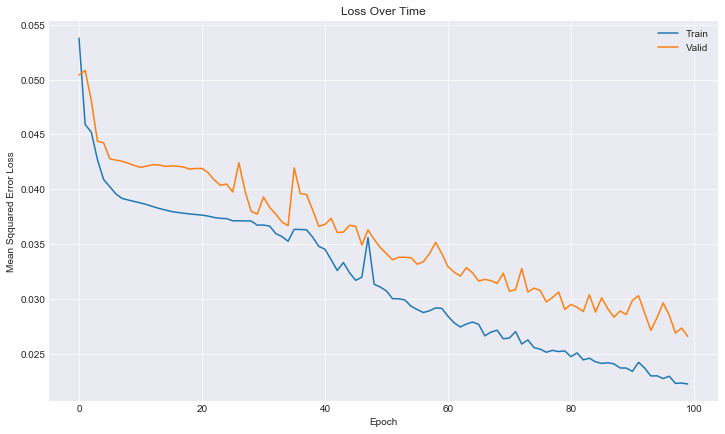

In [706]:
plot_loss(total_loss,total_val_loss)

In [707]:
input_seq_test = x_train[-60:].reshape((1,60,1))
output_seq_test = y_test[:20]
decoder_input_test = np.zeros((1,output_seq_len,1))

In [708]:
pred1 = model_1.predict([input_seq_test,decoder_input_test])

In [710]:
pred_values1 = scaler.inverse_transform(pred1.reshape(-1,1))
output_seq_test1 = scaler.inverse_transform(output_seq_test)

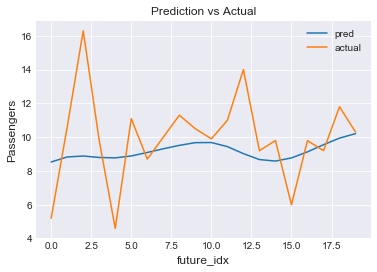

In [766]:
plt.plot(pred_values1, label = "pred")
plt.plot(output_seq_test1, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Temperature", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('uni_dir1.png')

### Bidirectional 1-Layered

In [712]:
model1_bi = create_model([60],bidirectional=True)

In [713]:
total_loss = []
total_val_loss = []
model1_bi.compile(Adam(), loss = 'mean_squared_error')

In [ ]:
#bi 1 layered model
start_time = time.time()
run_model(model1_bi,batches=1, epochs=100, batch_size=batch_size)
end_time = time.time()

In [715]:
run_time = (end_time - start_time)/60
run_time

16.264461223284403

In [716]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

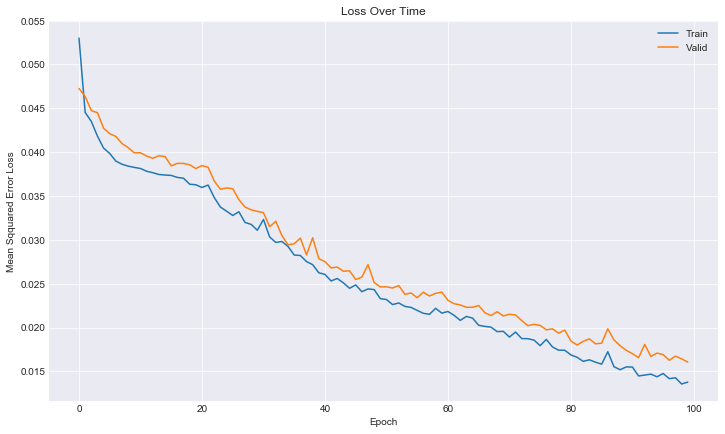

In [717]:
plot_loss(total_loss,total_val_loss)

In [768]:
input_seq_test = x_train[-60:].reshape((1,60,1))
output_seq_test = y_test[:20]
decoder_input_test = np.zeros((1,output_seq_len,1))

In [769]:
pred = model1_bi.predict([input_seq_test,decoder_input_test])

In [771]:
pred_values = scaler.inverse_transform(pred.reshape(-1,1))
output_seq_test = scaler.inverse_transform(output_seq_test)
input_seq_test = scaler.inverse_transform(input_seq_test.reshape(-1,1))

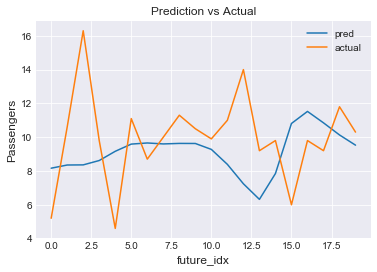

In [772]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Temperature", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('bi_dir1.png')

### Unidirectional 2-Layered

In [723]:
model_2 = create_model([60,60],bidirectional=False)

In [724]:
total_loss = []
total_val_loss = []
model_2.compile(Adam(), loss = 'mean_squared_error')

In [ ]:
start_time = time.time()
run_model(model_2,batches=1, epochs=100, batch_size=batch_size)
end_time = time.time()

In [726]:
run_time = (end_time - start_time)/60
run_time

20.265896781285605

In [ ]:
plot_loss(total_loss,total_val_loss)

In [728]:
input_seq_test = x_train[-60:].reshape((1,60,1))
output_seq_test = y_test[:20]
decoder_input_test = np.zeros((1,output_seq_len,1))

In [729]:
pred2 = model_2.predict([input_seq_test,decoder_input_test])

In [730]:
pred_values2 = scaler.inverse_transform(pred2.reshape(-1,1))
output_seq_test2 = scaler.inverse_transform(output_seq_test)

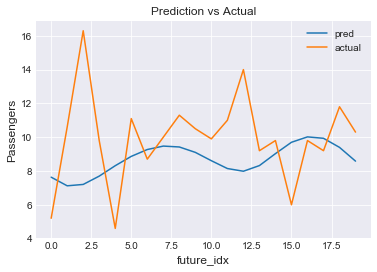

In [773]:
plt.plot(pred_values2, label = "pred")
plt.plot(output_seq_test2, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Temperature", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('uni_dir2.png')

### Bidirectional 2-Layered

In [732]:
model2_bi = create_model([60,60],bidirectional=True)

In [733]:
total_loss = []
total_val_loss = []
model2_bi.compile(Adam(), loss = 'mean_squared_error')

In [ ]:
start_time = time.time()
run_model(model2_bi,batches=1, epochs=100, batch_size=batch_size)
end_time = time.time()

In [735]:
run_time = (end_time - start_time)/60
run_time

42.29079427321752

In [ ]:
plot_loss(total_loss,total_val_loss)

In [737]:
input_seq_test = x_train[-60:].reshape((1,60,1))
output_seq_test = y_test[:20]
decoder_input_test = np.zeros((1,output_seq_len,1))

In [738]:
pred2_bi = model2_bi.predict([input_seq_test,decoder_input_test])

In [740]:
pred_values2_bi = scaler.inverse_transform(pred2_bi.reshape(-1,1))
output_seq_test2_bi = scaler.inverse_transform(output_seq_test)

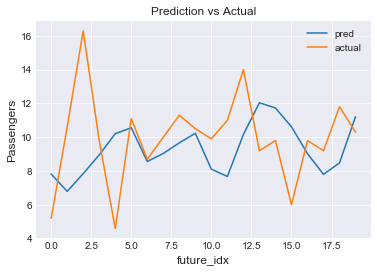

In [741]:
plt.plot(pred_values2_bi, label = "pred")
plt.plot(output_seq_test2_bi, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Temperature", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('bi_dir2.png')